In [1]:
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_spectrum

In [2]:
import astropy

In [3]:
plate = 1615
mjd = 53166
fiber = 513

spec = fetch_sdss_spectrum(plate, mjd, fiber)


caching to /home/mlares/astroML_data/SDSSspec/1615/spSpec-53166-1615-513.fit


In [4]:
spec.spectrum

array([ 127.76799774,  127.74199677,  127.71600342, ...,  221.06599426,
        221.06799316,  221.07000732], dtype=float32)

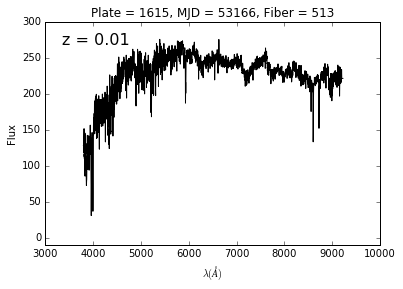

In [5]:
ax = plt.axes()
ax.plot(spec.wavelength(), spec.spectrum, '-k', label='spectrum')

ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())

ax.text(0.05, 0.95, 'z = %.2f' % spec.z, size=16,
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\lambda (\AA)$')
ax.set_ylabel('Flux')

ax.set_ylim(-10, 300)

plt.show()

In [6]:
from __future__ import print_function, division

import sys
from astroML.py3k_compat import HTTPError
import numpy as np
from astroML.datasets import fetch_sdss_spectrum
from astroML.datasets.tools import query_plate_mjd_fiber, TARGET_GALAXY
from astroML.dimensionality import iterative_pca


In [7]:
def fetch_and_shift_spectra(n_spectra,
                            outfile,
                            primtarget=TARGET_GALAXY,
                            zlim=(0, 0.7),
                            loglam_start=3.5,
                            loglam_end=3.9,
                            Nlam=1000):
    """
    This function queries CAS for matching spectra, and then downloads
    them and shifts them to a common redshift binning
    """
    # First query for the list of spectra to download
    plate, mjd, fiber = query_plate_mjd_fiber(n_spectra, primtarget,
                                              zlim[0], zlim[1])

    # Set up arrays to hold information gathered from the spectra
    spec_cln = np.zeros(n_spectra, dtype=np.int32)
    lineindex_cln = np.zeros(n_spectra, dtype=np.int32)

    log_NII_Ha = np.zeros(n_spectra, dtype=np.float32)
    log_OIII_Hb = np.zeros(n_spectra, dtype=np.float32)

    z = np.zeros(n_spectra, dtype=np.float32)
    zerr = np.zeros(n_spectra, dtype=np.float32)
    spectra = np.zeros((n_spectra, Nlam), dtype=np.float32)
    mask = np.zeros((n_spectra, Nlam), dtype=np.bool)

    # Calculate new wavelength coefficients
    new_coeff0 = loglam_start
    new_coeff1 = (loglam_end - loglam_start) / Nlam

    # Now download all the needed spectra, and resample to a common
    #  wavelength bin.
    n_spectra = len(plate)
    num_skipped = 0
    i = 0

    while i < n_spectra:
        sys.stdout.write(' %i / %i spectra\r' % (i + 1, n_spectra))
        sys.stdout.flush()
        try:
            spec = fetch_sdss_spectrum(plate[i], mjd[i], fiber[i])
        except HTTPError:
            num_skipped += 1
            print("%i, %i, %i not found" % (plate[i], mjd[i], fiber[i]))
            i += 1
            continue

        spec_rebin = spec.restframe().rebin(new_coeff0, new_coeff1, Nlam)

        if np.all(spec_rebin.spectrum == 0):
            num_skipped += 1
            print("%i, %i, %i is all zero" % (plate[i], mjd[i], fiber[i]))
            continue

        spec_cln[i] = spec.spec_cln

        lineindex_cln[i], (log_NII_Ha[i], log_OIII_Hb[i])\
            = spec.lineratio_index()

        z[i] = spec.z
        zerr[i] = spec.zerr

        spectra[i] = spec_rebin.spectrum
        mask[i] = spec_rebin.compute_mask(0.5, 5)

        i += 1
    sys.stdout.write('\n')

    N = i
    print("   %i spectra skipped" % num_skipped)
    print("   %i spectra processed" % N)
    print("saving to %s" % outfile)

    np.savez(outfile,
             spectra=spectra[:N],
             mask=mask[:N],
             coeff0=new_coeff0,
             coeff1=new_coeff1,
             spec_cln=spec_cln[:N],
             lineindex_cln=lineindex_cln[:N],
             log_NII_Ha=log_NII_Ha[:N],
             log_OIII_Hb=log_OIII_Hb[:N],
             z=z[:N],
             zerr=zerr[:N])

In [8]:
def spec_iterative_pca(outfile, n_ev=10, n_iter=20, norm='L2'):
    """
    This function takes the file outputted above, performs an iterative
    PCA to fill in the gaps, and appends the results to the same file.
    """
    data_in = np.load(outfile)
    spectra = data_in['spectra']
    mask = data_in['mask']

    res = iterative_pca(spectra, mask,
                        n_ev=n_ev, n_iter=n_iter, norm=norm,
                        full_output=True)

    input_dict = dict([(key, data_in[key]) for key in data_in.files])

    # don't save the reconstructed spectrum: this can easily
    # be recomputed from the other parameters.
    input_dict['mu'] = res[1]
    input_dict['evecs'] = res[2]
    input_dict['evals'] = res[3]
    input_dict['norms'] = res[4]
    input_dict['coeffs'] = res[5]

    np.savez(outfile,
             **input_dict)

In [9]:
fetch_and_shift_spectra(4000, 'spec4000.npz')

HTTPError: HTTP Error 404: Not Found

In [10]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.plotting.tools import discretize_cmap


In [11]:
# Fetch the data; coefficients have been pre-computed
data = fetch_sdss_corrected_spectra()
coeffs = data['coeffs']
c = data['lineindex_cln']

downloading PCA-processed SDSS spectra from http://www.astro.washington.edu/users/vanderplas/spec4000.npz to /home/mlares/astroML_data


AttributeError: 'NoneType' object has no attribute 'strip'

# Dimensionality Reduction Example

As with the previous example, this notebook assumes that the current
working directory is in the scikit-learn tutorial directory where
the notebook is stored. In the folder

     ../data/sdss_spectra

you’ll find the script which fetches a set of spectra from the
Sloan Digital Sky Survey. Each individual spectrum is at a particular
redshift, and can have data missing in certain spectral regions. So
that this doesn’t affect our analysis, the spectra have been de-redshifted
and the gaps have been filled using the PCA-based algorithm described in.
In the process of shifting and gap-filling, the spectra have been
down-sampled so that the number of attributes is n = 1000.

If you're using a different directory structure, then the ``DATA_HOME``
variable in the following script should be set accordingly.

In [32]:
import os
DATA_HOME = os.path.abspath('../sklearn_tutorial/doc/data/sdss_spectra/')

Once the dataset is downloaded, it can be read-in as follows:

In [33]:
import numpy as np
data = np.load(os.path.join(DATA_HOME,'spec4000_corrected.npz'))

BadZipfile: Bad magic number for central directory

In this case ``data`` is a ``npz`` archive, consisting of several arrays
zipped together.  We can see the various arrays in the ``files`` attribute:

In [15]:
data.files

Exception AttributeError: "'NpzFile' object has no attribute 'zip'" in <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7fe7cea6a910>> ignored


NameError: name 'data' is not defined

In [16]:
data['X'].shape

NameError: name 'data' is not defined

In [17]:
print data['labels']

SyntaxError: invalid syntax (<ipython-input-17-c45a3827842b>, line 1)

## Visualizing the Data

The variable X contains 4000 spectra, each with 1000 attributes. In addition,
the file includes a classification code y, and redshift z for each spectrum,
and an array wavelengths which can aid in plotting spectra. Let’s plot a few
of these to see what they look like, making sure to choose a representative
of each of the interesting classes:

In [18]:
%pylab inline
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


In [19]:
def plot_spectral_types(data):
    X = data['X']
    y = data['y']
    wavelengths = data['wavelengths']
    labels = data['labels']

    for i_class in (2, 3, 4, 5, 6):
        i = np.where(y == i_class)[0][0]
        l = pl.plot(wavelengths, X[i] + 20 * i_class)
        c = l[0].get_color()
        pl.text(6800, 2 + 20 * i_class, labels[i_class], color=c)
   
    pl.subplots_adjust(hspace=0)
    pl.xlabel('wavelength (Angstroms)')
    pl.ylabel('flux + offset')
    pl.title('Sample of Spectra')

In [20]:
plot_spectral_types(data)

NameError: name 'data' is not defined

There are 4000 spectra in this file, each with 1000 attributes. Visualizing
a dataset of this size can be very difficult. We could plot all 4000 spectra
as we did above, but the plot would quickly become too complicated. As a
first step, it might be helpful to ask what the average spectrum looks like.
To do this, we’ll plot the mean, but first we’ll normalize the spectra.
Because the spectra represent galaxies at distances that range over several
hundreds of light-years, their total flux varies greatly. Thus it will
help if we normalize the spectra. For this we’ll use the scikit-learn
preprocessing module. We’ll then plot both the mean and standard
deviation to give us an idea of the data we’re working with:

In [ ]:
from sklearn.preprocessing import normalize

def plot_mean_std(data):
    X = data['X']
    wavelengths = data['wavelengths']
    
    X = normalize(X)
    mu = X.mean(0)
    std = X.std(0)
    pl.plot(wavelengths, mu, color='black')
    pl.fill_between(wavelengths, mu - std, mu + std, color='#CCCCCC')
    pl.xlim(wavelengths[0], wavelengths[-1])
    pl.ylim(0, 0.06)
    pl.xlabel('wavelength (Angstroms)')
    pl.ylabel('scaled flux')
    pl.title('Mean Spectrum')

In [ ]:
plot_mean_std(data)

The mean and standard deviation of the normalized spectra. Some of
the largest variation is found at wavelengths at which Hydrogen
absorbs and emits photons (Hydrogen is by far the most abundant
atom in the universe). For example, the line at 6563 is known as
Hydrogen-$\alpha$, and is often seen in emission (spiking up) in
quasars and other active galaxies.

The interesting part of the data is in the gray shaded regions: how
do spectra vary from the mean, and how can this variation tell us
about their physical properties? One option to visualize this would
be to scatter-plot random pairs of observations from each spectrum.
We’ll first create a formatter object to make the colorbar labels pretty:

Now we create a function to plot the data:

In [ ]:
from sklearn.preprocessing import normalize

def plot_random_projection(data, rseed=25255):
    # rseed is chosen to emphasize correlation
    np.random.seed(rseed)  
    i1, i2 = np.random.randint(1000, size=2)
    
    # create a formatter which works for our labels
    format = pl.FuncFormatter(lambda i, *args: labels[i].replace(' ', '\n'))
    
    X = normalize(data['X'])
    y = data['y']
    labels = data['labels']
    wavelengths = data['wavelengths']
    
    pl.scatter(X[:, i1], X[:, i2], c=y, s=4, lw=0,
               vmin=2, vmax=6, cmap=pl.cm.jet)
    pl.colorbar(ticks = range(2, 7), format=format)
    pl.xlabel('wavelength = %.1f' % wavelengths[i1])
    pl.ylabel('wavelength = %.1f' % wavelengths[i2])
    pl.title('Random Pair of Spectra Bins')

In [ ]:
plot_random_projection(data)

There is a clear correlation between these two measurements. That is,
if you know the value of one, then you could quite accurately predict
the value of the other. This shows us that some of the spectral bins
do not add much information, and can be ignored. One could imagine
proceeding by trial and error, plotting pairs of points and seeing which
ones provide the most interesting information, but this would be very
tedious. Instead, we can use an automated technique for dimensionality
reduction, one well-known example of which is Principal Component Analysis.

## Principal Component Analysis

Principal Component Analysis (PCA) is an often-used tool in astronomy
and other data-intensive sciences. In a sense, it automates the
trial-and-error process discussed in the previous section, and finds
the most interesting linear combinations of attributes, so that
high-dimensional data can be visualized in a 2D or 3D plot. Scikit-learn
has methods to compute PCA and several variants. Classic PCA
(sklearn.decomposition.PCA) is based on an eigenvalue decomposition of
the data covariance, so that for N points, the computational cost grows
as $\mathcal{O}[N^3]$. This means that for large datasets like the current
one, the fit can be very slow. You can try it as follows, but the
computation may take up to several minutes for this dataset:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

X = data['X']

# warning: this next command takes a long time!
#X_projected = pca.fit_transform(X)

Fortunately, scikit-learn has an alternative method that is much faster.
The speed comes at a price: it is based on random projections, so the
results are not as robust as the normal method. But for tasks such as
ours where we are seeking only a few of a large number of eigenvectors,
it performs fairly well. To keep our results consistent between runs,
we’ll explicitly set the random seed for the fit. You should repeat this
with several different random seeds to convince yourself that the results
are consistent:

In [ ]:
from sklearn.decomposition import RandomizedPCA
rpca = RandomizedPCA(n_components=4, random_state=0)

X = normalize(data['X'])
X_proj = rpca.fit_transform(X)

print X_proj.shape

``X_proj`` is now a reduced-dimension representation of ``X``, where the lower-index columns are the most important dimensions. We can visualize the spectra now using the first two columns:

In [ ]:
def plot_PCA_projection(data, rpca):
    y = data['y']
    
    # create a formatter which works for our labels
    labels = data['labels']
    format = pl.FuncFormatter(lambda i, *args: labels[i].replace(' ', '\n'))
    
    X_proj = rpca.transform(X)

    pl.scatter(X_proj[:, 0], X_proj[:, 1], c=y, s=4, lw=0, vmin=2, vmax=6, cmap=pl.cm.jet)
    pl.colorbar(ticks = range(2, 7), format=format)
    pl.xlabel('coefficient 1')
    pl.ylabel('coefficient 2')
    pl.title('PCA projection of Spectra')

In [ ]:
plot_PCA_projection(data, rpca)

We now have a two-dimensional visualization, but what does this tell us? Looking at the PCA model in the equation above, we see that each component is associated with an eigenvector, and this plot is showing $a_{i1}$ and $a_{i2}$ where

   $\vec{s_i} \approx \vec{\mu} + a_{i1}\vec{v_1} + a_{i2}\vec{v_2}$

Visualizing the eigenvectors $\vec{v_j}$ can give insight into what these components mean:

In [ ]:
def plot_eigenvectors(data, rpca):
    wavelengths = data['wavelengths']
    
    l = pl.plot(wavelengths, rpca.mean_ - 0.15)
    c = l[0].get_color()
    pl.text(7000, -0.16, "mean", color=c)
    
    for i in range(4):
        l = pl.plot(wavelengths, rpca.components_[i] + 0.15 * i)
        c = l[0].get_color()
        pl.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
        
    pl.ylim(-0.2, 0.6)
    pl.xlabel('wavelength (Angstroms)')
    pl.ylabel('scaled flux + offset')
    pl.title('Mean Spectrum and Eigen-spectra')

In [ ]:
plot_eigenvectors(data, rpca)

We see that the first eigenspectrum (component 1) tells us about the
relative difference in flux between low wavelengths and high wavelengths
- that is, the color of the spectrum. Component 2 tells us a lot about
the emission and absorption characteristics in the various lines, and
also in the so-called “4000 angstrom break” due to Hydrogen absorption.
Detailed analysis of these components and eigenspectra can lead to much
physical insight about the galaxies in the fit.

Nevertheless, there are some weaknesses here. First of all, PCA does not
do a good job of separating out galaxies with different emission
characteristics. We’d hope for a projection which reflects the fact that
narrow spectral features are very important in the classification. PCA
does not do this. In a later exercise, we’ll explore some alternative
nonlinear dimensionality reduction techniques which will address this
deficiency of PCA.